<center> <h1>Preliminary analysis </h1> </center>

Here, we propose to start analyzing the data obtained from quandl to assess how to build on network. The data at hand corresponds to the adjusted closing prices of 2342 stocks on the NYSE for a period of 3 years (789 business days, from 01-03-2012 to 01-08-2015). We also have information on 1,129 of these stocks (sector and industry).

## I. Preparing the data

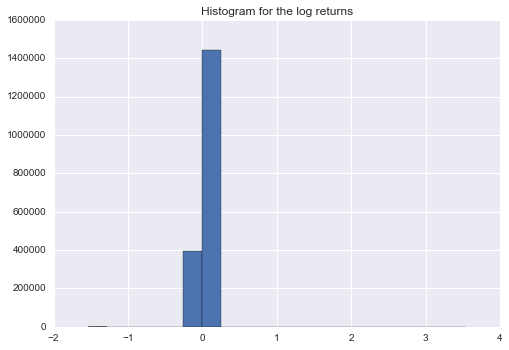

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import quandl
from utils_preprocessing import *
from correlation import *
from market_alphas import *
from regression import *
from extract_sectors import *


path='/Users/cdonnat/Dropbox/Financial Networks/data/'
sys.path.append(path)
stock_data=pickle.load(open(path+'stock_data.pkl','rb'))
Volume_data=pickle.load(open(path+'volume_data.pkl','rb'))
new_stock_data,nb_missing_values,day_missing_values=treat_missing_data(stock_data,verbose=False)
data_log=transform_stock(new_stock_data)
verbose=True
if verbose==True:
    plt.figure()
    plt.hist(data_log.as_matrix().reshape([-1,1]),bins=20)
    plt.title('Histogram for the log returns')
    plt.show()

There seems to be a few outliers, that is, stocks that exhibit abnormally  very small log-returns. It thus seems a good dea to start capping the data.

In [4]:
### Cap some outliers
thres=5*(data_log.as_matrix().reshape([-1,1])).std()
data_log=data_log.applymap(lambda x: cap(x,thres))

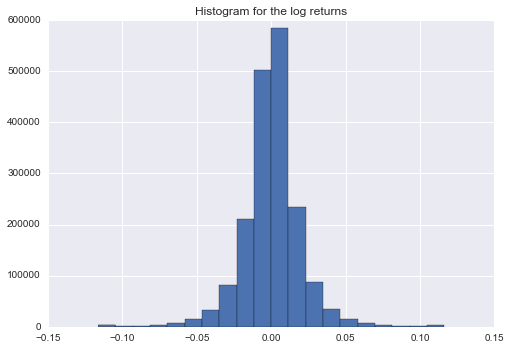

(1838470,)


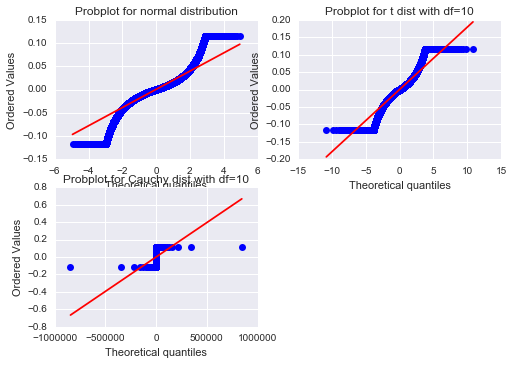

In [5]:
## Plot
if verbose==True:
        plt.figure()
        plt.hist(data_log.as_matrix().reshape([-1,1]),bins=20)
        plt.title('Histogram for the log returns')
        plt.show()
        
        ## Check normality assumptions
        from scipy import stats
        x=data_log.as_matrix().reshape([-1,])
        print x.shape
        fig = plt.subplot(221)
        res = stats.probplot(x, dist='norm',plot=fig)
        fig.set_title("Probplot for normal distribution")
        
        ax2 = plt.subplot(222)
        res = stats.probplot(x,dist=stats.t, sparams=(10) ,plot=ax2)
        ax2.set_title("Probplot for t dist with df=10")
        
        
        ax3 = plt.subplot(223)
        res = stats.probplot(x,dist=stats.cauchy ,plot=ax3)
        ax3.set_title("Probplot for Cauchy dist with df=10")
        plt.show()
        


## II. Taking out  the "market-effect"


We want to account for the market effect, that is, the fact that all stocks are "carried" by the market and a fraction of their behavior can be explained by the state of the overall market.

To that end, we compute an overall market return, defined as the weighted mean of the log-returns, where the weight for each stock $s$ on a daily basis corresponds to its average value traded over each day $d$ of the period. Denoting as $r_{sd} =\log(P_{s,d+1}/P_{s,d}$ the log-return for stock $s$ at time d, we have:

$$ \forall s, \quad w_s=\frac{\sum_{d} \text{Volume_traded}_{d,s}\times r_{sd} }{\sum_{s,d} \text{Volume_traded}_{d,s} \times r_{sd}} $$


$$\implies \forall d, \quad r^{(m)}_d=\sum_{s} w_s r_{sd}$$
This is just a first suggestion, there are probably some better ways of defining a market return.

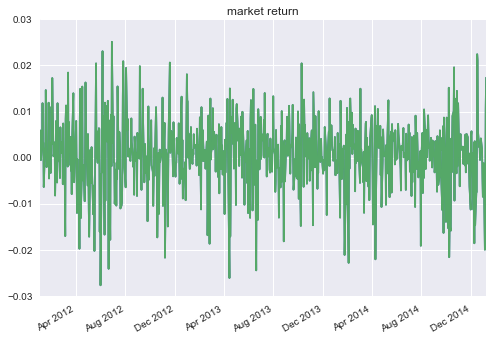

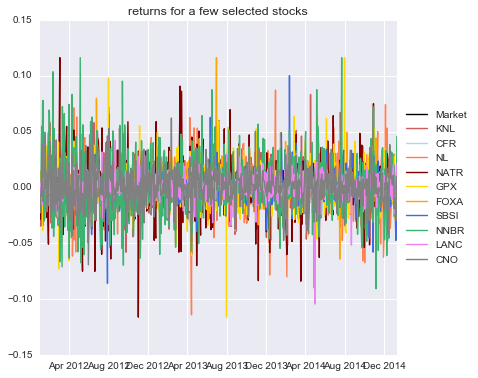

In [6]:
### threshold
stock_returns=data_log.copy()
r_m=compute_market_alpha(stock_data,stock_returns,Volume_data,plot=True)
r_m.plot(title='market return')
from datetime import datetime
import matplotlib.dates as mdates
colors=['indianred','lightblue','coral','maroon','gold','orange','royalblue','mediumseagreen','violet','grey']
bunch=np.random.choice(data_log.columns,10)
fig, ax = plt.subplots(figsize=(8,6))
sns.set(style='ticks')
sns.set_context("paper", font_scale=1.3)
plt.plot_date(x=data_log.index, y=r_m,c='black',label='Market',fmt='-')
it_b=0
for b in bunch:
    plt.plot_date(x=data_log.index, y=data_log[b],c=colors[it_b],label=b,fmt='-')
    it_b+=1
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('returns for a few selected stocks')
plt.show()
coeff,intercept,MSE,R2=regress_stock_against_market(data_log,r_m,K=5)


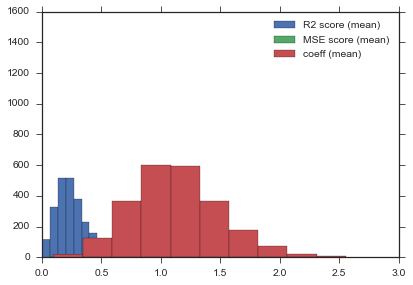

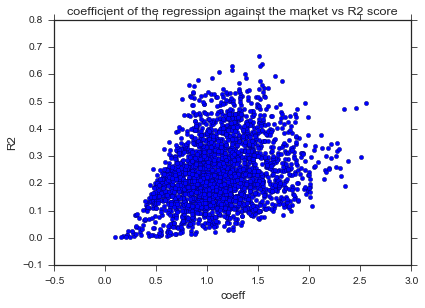

In [7]:
plt.hist(R2.mean(0),label='R2 score (mean)')
plt.hist(MSE.mean(0),label='MSE score (mean)')
plt.hist(coeff.mean(0),label='coeff (mean)')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.scatter(coeff.mean(0),R2.mean(0))
plt.xlabel('coeff')
plt.ylabel('R2')
plt.title('coefficient of the regression against the market vs R2 score')


## III. Regress against the market 

The idea here is that we want to remove the overall "market trend effect" from the log-returns. The proposed way here is to compute this market trend  (which is taken to be a weighted average of the log-returns, where the weights correspond to the volume of each stock traded over the day). We then only focus on investigating the residuals.


In [8]:
betas=pd.DataFrame(coeff.mean(0)).T
betas=pd.concat([betas]*data_log.shape[0], ignore_index=True)
betas.index=r_m.index
alphas=pd.DataFrame(intercept.mean(0)).T
alphas=pd.concat([alphas]*data_log.shape[0], ignore_index=True)
alphas.index=r_m.index
r_m_df=pd.concat([r_m]*data_log.shape[1], axis=1)
r_m_df.columns=betas.columns
market_effect=betas*r_m_df+alphas
stock_residuals=stock_returns-market_effect


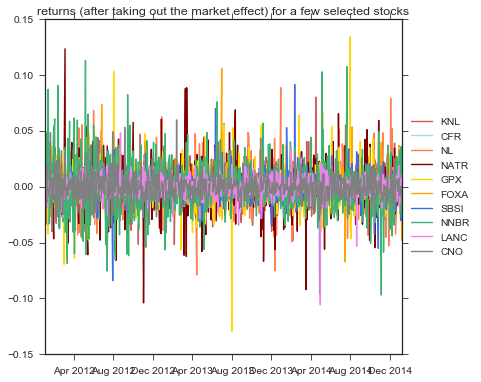

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set(style='ticks')
sns.set_context("paper", font_scale=1.3)
it_b=0
for b in bunch:
    plt.plot_date(x=data_log.index, y=stock_residuals[b],c=colors[it_b],label=b,fmt='-')
    it_b+=1
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('returns (after taking out the market effect) for a few selected stocks')
plt.show()
plt.show()

In [ ]:
(stock_residuals.iloc[:,:10]).plot(kind='hist')
plt.plot(stock_residuals.reshape([-1,1]))

### Investigate correlations 

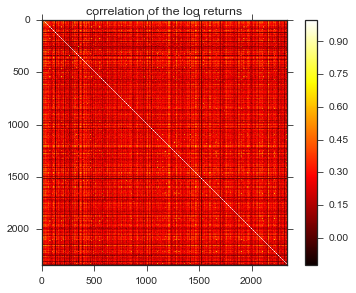

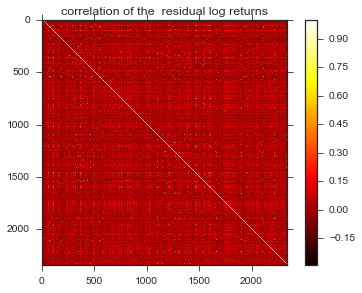

In [11]:
### Investigate correlations 
cor_returns=stock_returns.corr()
cor_res=stock_residuals.corr()

plt.figure()
plt.imshow(cor_returns,cmap='hot')
plt.title('correlation of the log returns')
plt.colorbar()


plt.figure()
plt.imshow(cor_res,cmap='hot')
plt.title('correlation of the  residual log returns')
plt.colorbar()

### Market betas

In [12]:
Betas=pd.DataFrame(betas.iloc[0,:])
Betas.columns=['beta']
CompanySector,CompanyIndustry,CompanyInfo=load_sectors(path)
Betas=Betas.merge(CompanyInfo.T,right_index=True,left_index=True)
Alphas=pd.DataFrame(alphas.iloc[0,:])
Alphas.columns=['alpha']


Betas=Betas.merge(Alphas,right_index=True,left_index=True)
sec=pd.DataFrame(np.unique(Betas['Sector']))
sec['key_sector']=sec.index
ind=pd.DataFrame(np.unique(Betas['Industry']))
ind['key_industry']=ind.index
ind_beta=Betas.index
Betas=Betas.merge(sec,left_on='Sector',right_on=0)
Betas=Betas.merge(ind,left_on='Industry',right_on=0)
del Betas['0_y']
del Betas['0_x']
Betas.index=ind_beta
ind=pd.DataFrame(np.unique(Betas['Industry']))

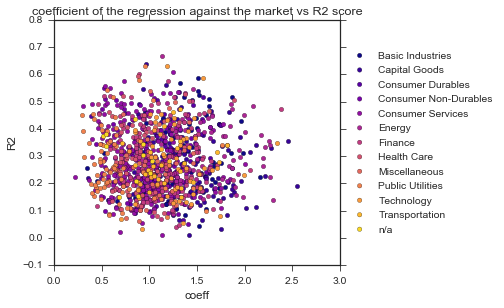

In [13]:
R2_mean=pd.DataFrame(R2.mean(0))
R2_mean.columns=['R2']
x=np.linspace(0,1,sec.shape[0])
cmap=plt.get_cmap('plasma')
colors_sec={}
it=0
for u in sec[0]:
    colors_sec[u]=cmap(it*1.0/sec.shape[0])
    it+=1
Betas=Betas.merge(R2_mean,right_index=True,left_index=True)
label_sec=[Betas.loc[u,'Sector'] for u in Betas.index]
label_colors=[colors_sec[Betas.loc[u,'Sector']] for u in Betas.index]
plt.figure()
ax = plt.subplot(111)
for s in sec[0]:
    ind_s=(Betas['Sector']==s)
    try:
        col=colors_sec[s]
    except:
        colors_sec[s]='black'
        col=colors_sec[s]
    plt.scatter(Betas.loc[ind_s,'beta'],Betas.loc[ind_s,'R2'],c=col,label=s)
plt.xlabel('coeff')
plt.ylabel('R2')
plt.title('coefficient of the regression against the market vs R2 score')
#plt.legend(loc='upper left')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

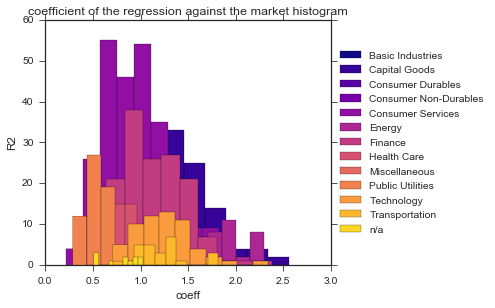

In [15]:
plt.figure()
ax = plt.subplot(111)
for s in sec[0]:
    ind_s=(Betas['Sector']==s)
    try:
        col=colors_sec[s]
    except:
        colors_sec[s]='black'
        col=colors_sec[s]
    (Betas.loc[ind_s,'beta']).plot(kind='hist',color=col,label=s)

plt.xlabel('coeff')
plt.ylabel('R2')
plt.title('coefficient of the regression against the market histogram')
#plt.legend(loc='upper left')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

0.05
0.0 1.0


/Users/cdonnat/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


0.075
0.0 1.0
0.1
0.0 1.0
0.125
0.0 1.0
0.15
0.0 1.0
0.175
0.0 1.0
0.2
0.0 1.0
0.4
0.0 1.0
0.5
0.0 1.0


AttributeError: 'module' object has no attribute 'xtitle'

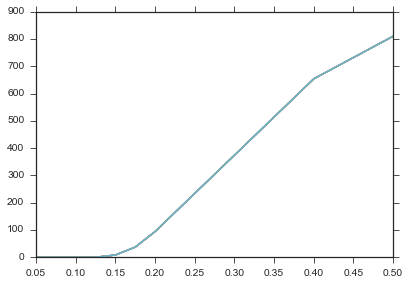

In [16]:
from consistency import *

thres_array=np.sort([0.5,0.4,0.2,0.175,0.15,0.125,0.1,0.075,0.05])
degree=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
consistency=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
diversity=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
cor_res=stock_residuals.corr()
for thres in thres_array:
    print thres
    cor_res=cor_res.applymap(lambda x: x*(np.abs(x)>thres))
    print np.min(np.min(np.abs(cor_res))),np.max(np.max(np.abs(cor_res)))
    ## Check diag
    sector_consistency_temp=sector_consistence(Betas,cor_res)
    consistency[thres]=sector_consistency_temp['consistency']
    diversity[thres]=sector_consistency_temp['diversity']
    degree[thres]=sector_consistency_temp['degree']
    #plt.hist(sector_consistency_temp['diversity'])
    #plt.hist(sector_consistency_temp['consistency'],bins=30)
    #plt.hist(sector_consistency_temp['degree'],bins=30)
    
### Most consistent stocks per threshold\
l={}
overlap=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
for thres in thres_array:
    l[thres]=consistency[thres][consistency[thres].argsort()>Betas.shape[0]-200]
    overlap.loc[l[thres].index,thres]+=1



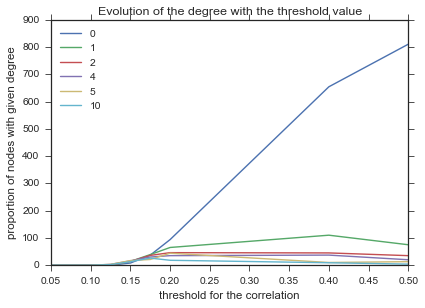

In [20]:
plt.figure()
for d in [0,1,2,4,5,10]:    
    plt.plot(thres_array,[np.sum(degree[t]==d) for t in thres_array],label=d)
plt.xlabel('threshold for the correlation')
plt.ylabel('proportion of nodes with given degree')
plt.title('Evolution of the degree with the threshold value')
plt.legend(loc='upper left')
plt.show()

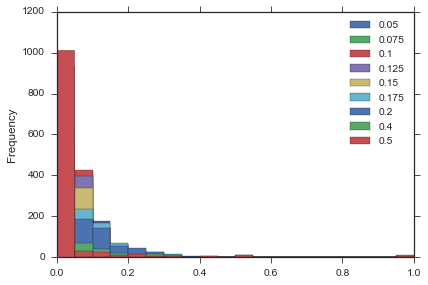

In [25]:
consistency.plot(kind='hist',bins=20)

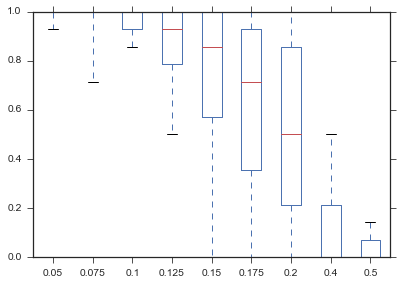

In [35]:
plt.figure()
diversity.plot(kind='box')
#plt.xlabel('correlation threshold')
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1566ade50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x157db1650>], dtype=object)

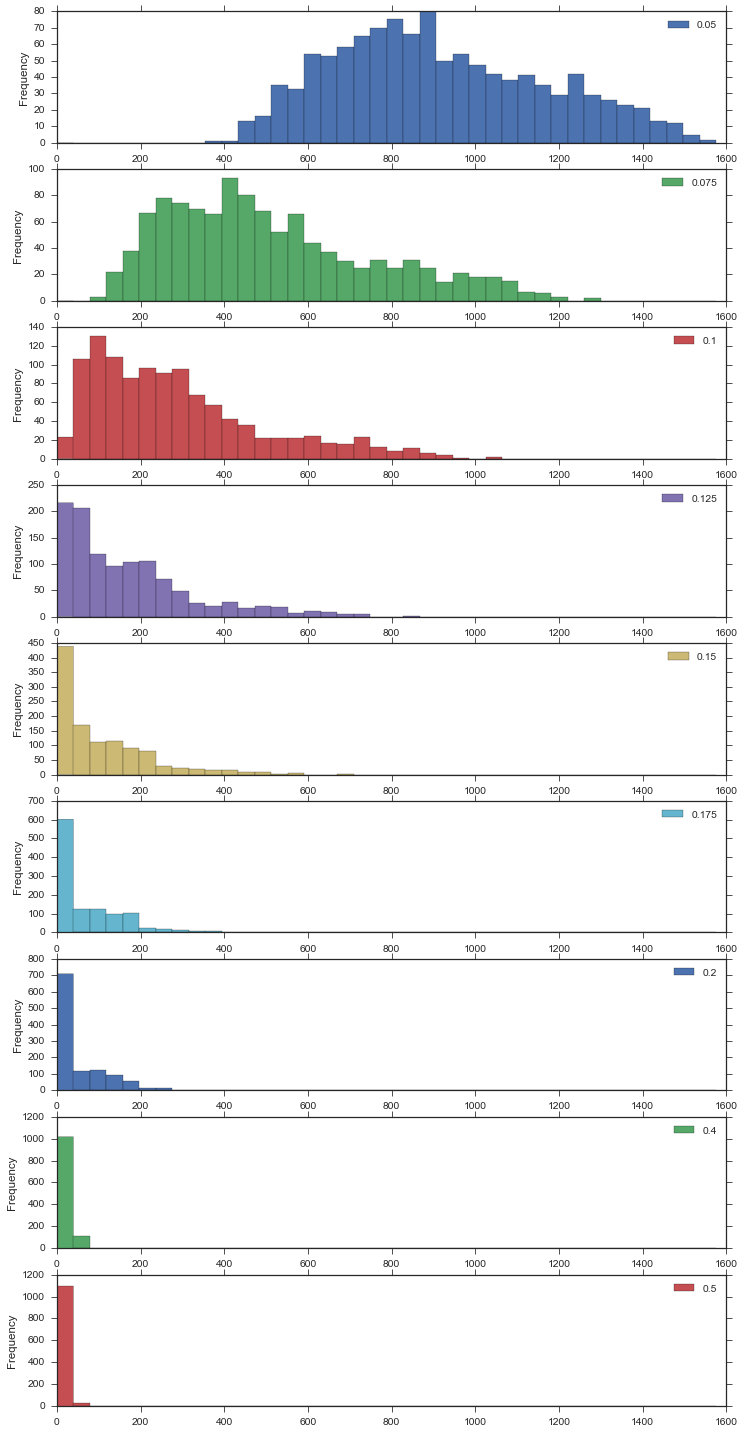

In [52]:
degree.plot(kind='hist',subplots=True,sharex=False,figsize=(12,25),bins=40)

TypeError: 'str' object is not callable

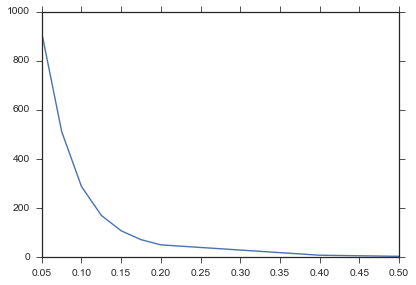

In [58]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
plt.plot(thres_array, [degree[t].mean() for t in thres_array])
plt.xlabel('Correlation threshold')
plt.ylabel('Average degree')
plt.show()

In [59]:
import rpy2
import rpy2.robjects as robjects